In [1]:
from tqdm.auto import tqdm
import pandas as pd
tqdm.pandas() # activate the tqdm for pandas

import matplotlib.pyplot as plt

from copy import copy
import re
import json
import os

# to use data structures
from pydantic import BaseModel

# OpenAI API
from openai import OpenAI

# Load the API keys from .env
from dotenv import load_dotenv

In [2]:
# now we want to load the API keys from the .env file
load_dotenv(".env")

#check that we have the needed keys
for api_key in ["OPENAI_API_KEY"]:
    if os.getenv(api_key) != None:
        print(api_key, "loaded")
    else:
        print(api_key,"missing")
        print("Please create a .env file with the corresponding API key")

OPENAI_API_KEY loaded


# OpenAI's API calls

We first need to initialize the OpenAI client.

> If the code bellow doesn't work, make sure that the `OPEN_AI_KEY` is loaded

In [3]:
openai_client = OpenAI();

We will use the cheapest model `gpt-4o-mini` for all the following codes

The messages is the main input of the API. Think of it as the chatbox. `system` messages you can think of as the general instructions, while the `prompt` is the input for those instructions.

In [4]:
msg = [
    {
        "role": "system", "content": "Write me a poam about the topic of the following text. It should be a short poem, no more than 4 lines. The poem should be in the style of a haiku. The text is: "},
    {
        "role": "user", "content": "economics graduate student"
        }
]

In [5]:
completion = openai_client.chat.completions.create(
        model="gpt-4o-mini",  # specify the model                                           
        messages=msg
    )

In [6]:
completion

ChatCompletion(id='chatcmpl-BFq4mxf5M231Dw5Qagq8Xf3RUmJ0K', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Knowledge built on charts,  \nNumbers dance in measured steps,  \nFuture's path awaits.", refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1743114800, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_86d0290411', usage=CompletionUsage(completion_tokens=19, prompt_tokens=59, total_tokens=78, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

The variable `completion` will now return with a bunch of data inside (for more detaisl please visit [OpenAI's documentation](https://platform.openai.com/docs/concepts)). 

To get to the text output:

In [10]:
poem = completion.choices[0].message.content
print(poem)

Knowledge built on charts,  
Numbers dance in measured steps,  
Future's path awaits.


You can also get back a `pydantic` type from the [structured outputs](https://platform.openai.com/docs/guides/structured-outputs?api-mode=responses#page-top). For this we have to define some structure for our outputs:

In [18]:
class Poem(BaseModel):
    title: str
    poem: str
    sad: bool

I will change the `msg` so that it also tells me if the poem is sad or not. For this, I added a line `sad` and it can take the values True or False.

In [19]:
msg = [
    {
        "role": "system", "content": "Write me a poam about the topic of the following text. It should be a short poem, no more than 4 lines. The poem should be in the style of a haiku. Please also tell me if you think the poem is sad or not and create a title for the poem. The text is: "},
    {
        "role": "user", "content": "economics graduate student"
        }
]

In [20]:
completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=msg,
        max_completion_tokens = 1024*6,   # this sets the max of tokens it can return 
                                          # remember that API calls take money from tokens, so more token more expensive
        response_format=Poem,           # this is the response format we want to get defined before
    )

In [21]:
# Get the strutured object
out = completion.choices[0].message.parsed
out

Poem(title='Chasing Numbers', poem='Lessons and numbers,  \nDreams wrapped in graphs and charts,  \nFuture on the line,  \nEchoes of the past haunt.', sad=True)

In [ ]:
# you can turn the obejct into a dict / json
out.model_dump()

{'title': 'Chasing Numbers',
 'poem': 'Lessons and numbers,  \nDreams wrapped in graphs and charts,  \nFuture on the line,  \nEchoes of the past haunt.',
 'sad': True}

In [23]:
# you can turn the obejct into a dict / json
out.model_dump_json()

'{"title":"Chasing Numbers","poem":"Lessons and numbers,  \\nDreams wrapped in graphs and charts,  \\nFuture on the line,  \\nEchoes of the past haunt.","sad":true}'

## Using data

I have a dataset of the responses of psycologists to comments from patients from [Kaggle](https://www.kaggle.com/datasets/thedevastator/nlp-mental-health-conversations?resource=download)

I want to use the generative AI to clasify the comments of the psycologist as appropiate or not

In [2]:
mental_health = pd.read_csv("data/mental_health.csv")
mental_health.rename(columns={"Context": "Comment"}, inplace=True)
mental_health.dropna(inplace=True)

# take a sample of 20 responses
mental_health = mental_health.sample(20, random_state=1337)
mental_health

,Comment,Response
3296,"My boyfriend is in Ireland for 11 days, and I ...",It sounds like you and your boyfriend are very...
2011,I have so many issues to address. I have a his...,I think this is a very common question that pe...
1683,"After 40 years of being straight, how could I ...",Sexuality is normally formed during adolescenc...
1560,I feel like I took our relationship for grante...,A key factor in a relationship is trust.I'd st...
1267,"I crave attention, companionship, and sex. She...","Hi Hampton,Although I'd bet your wife also wan..."
2895,He said he would try and he never did. It's be...,If your husband is changing his mind about whe...
2697,"I always feel the need to impress people, whet...",It is normal to seek other’s attention and not...
1042,We're in an eight year relationship. My boyfri...,"First, let me extend my compassion to both of ..."
3312,I've gone to a couple therapy sessions so far ...,"Yes, it is completely normal to feel anxious a..."
2788,He is an adolescent. He has peed his pant mult...,"Sounds as though your son is ""pissed off"" abou..."


In [ ]:
def create_msg(row):
    msg = [
        {
            "role": "system", "content": "Read the folling comversation between two people. The first person a patient and the second one is a mental health professional. Please rate from 1-5 how appropiate you think is the response of the mental health professional. 1 is not appropiate at all and 5 is very appropiate. Please provide a confidence level of your rating from 50 (uncertain) to 100 (certain) and show your logical thinking as 'cot' "
        },
        {
            "role": "user", "content": "Patient: " + row["Comment"] + "\n Mental Health Professional: " + row["Response"] + "\n"
        }
    ]
    return msg

In [47]:
mental_health['msg'] = mental_health.progress_apply(create_msg, axis=1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [56]:
class Response(BaseModel):
    rating: int
    confidence: int
    cot: list[str]

In [57]:
def structured_API_call(msg):
    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=msg,
        max_completion_tokens = 1024*6,                # Most likely will need this high for the cot
        response_format=Response,           # this is the response format we want to get defined before
    )

    return completion.choices[0].message.parsed

In [58]:
answers = mental_health['msg'].progress_apply(structured_API_call)

  0%|          | 0/20 [00:00<?, ?it/s]

In [63]:
ratings = [obj.rating for obj in answers]
confidence = [obj.confidence for obj in answers]
cot = [obj.cot for obj in answers]

mental_health['rating'] = ratings
mental_health['confidence'] = confidence
mental_health['cot'] = cot

<Axes: xlabel='rating'>

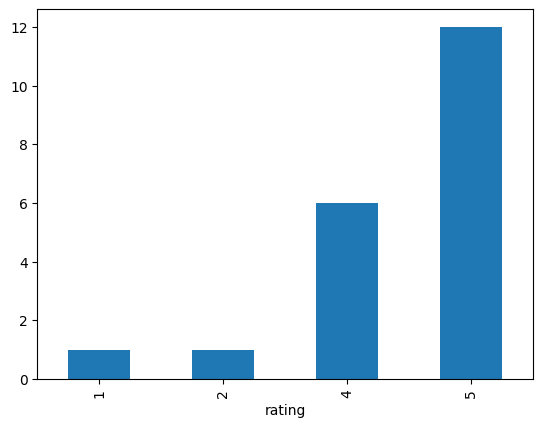

In [64]:
mental_health['rating'].value_counts().sort_index().plot(kind='bar')

In [68]:
# what where the ones with lower ratings?
low_ratings = mental_health[mental_health['rating'] < 3]

for row in low_ratings.iterrows():
    print("Comment: ", row[1]['Comment'])
    print("Response: ", row[1]['Response'])
    print("Rating: ", row[1]['rating'])
    print("Confidence: ", row[1]['confidence'])
    print("Cot: ", row[1]['cot'])
    print("\n")

Comment:  I've pretty much been on my own since day one, I'm a middle child of five, and I can't seem to put my trust in anyone. It took me four years to finally open up a little to my best friend. Every time I realize that I have feelings for someone, I freak out and never talk to them again. I really want some help.
Response:  One way to concentrate is that if your mind starts to wonder then remind yourself to bring your attention back.Start with short time spans of expecting yourself to concentrate.  You'll more likely succeed with concentrating with small time spans than longer ones.Once you start seeing your success, this will motivate you to try increasing the length to expect yourself to concentrate.The task of self-reminding is the same, whether for long or short time periods.Also, before starting this exercise ask your medical doctor if the problem can be related to a physical health problem.If there is, then have the possibility ruled out that your difficulty concentrating co

# Open source with HuggingFace

Instead of paying for API calls we can use the computer resources. For this we use the package transformers!

In this case we will use a super lightweight model, so we don't overwhelm the computer

In [19]:
import torch

In [20]:
# check to see that GPU's are active and how many
gpu_avail = torch.cuda.is_available()
mps_avail = hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()

if gpu_avail:
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}:")
        print(f"  Name: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")
elif mps_avail:
    print("MPS (Metal Performance Shaders) is available for macOS GPU acceleration")
else:
    print("No GPU or MPS detected. Please check you asked for the resources or have a GPU on your computer")

MPS (Metal Performance Shaders) is available for macOS GPU acceleration


If you are using the SuperPod HPC, you can see almost 80gb of VRAM to use!

If you see that GPU or MPS is not detected, the model will be loaded on the CPU and inference will be super slow.

For this notebook we will use a lightweight model that will take no more than 4gb of VRAM.

In [21]:
from transformers import pipeline

We now load the model using [`pipeline`](http://bcm-dgxa100-0005:8888/lab?token=3179442dd49254ece431fe36b5e001dda40c6a5ed48247a8) which simplifies a lot of the model configuration.

We will use small version of [Mistral](https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503) from this [Huggingface repo](https://huggingface.co/alamios/Mistral-Small-3.1-DRAFT-0.5B). Because of the size, performance will not be great. 

However, I've been able to run big models like [Deepseek Llama 3.3-70b](https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Llama-70B) at full precision (or quantization) in 2 SuperPod GPUs.

In [ ]:
pipe = pipeline(
    "text-generation", 
    model="alamios/Mistral-Small-3.1-DRAFT-0.5B", 
    trust_remote_code=True,
    do_sample=True,
    max_new_tokens = 1024*3,
    )

Once loaded we can ask it to create the a econ poem

> Note: some models are not trained to use the 'system' message, so we just combine the whole prompt into 1

In [ ]:
msg = [
    {
        "role": "user", "content": "Write me a poam about the topic of the following text. It should be a short poem, no more than 4 lines. The text is: economics graduate student"
        }
]
out = pipe(msg)
out

[{'generated_text': [{'role': 'user',
    'content': 'Write me a poam about the topic of the following text. It should be a short poem, no more than 4 lines. The text is: economics graduate student'},
   {'role': 'assistant',
    'content': 'In the quiet of the night,\nI wake to the hum of the world.\nThe clock chimes softly,\nAs I reflect on the day.'}]}]

In [ ]:
print(out[0]['generated_text'][1]['content'])

In the quiet of the night,
I wake to the hum of the world.
The clock chimes softly,
As I reflect on the day.


Now let's see how does it do with the health dataset

> I will also simplify the message a bit so that we can get something usefull from this small model

In [ ]:
def create_msg(row):
    msg = [
        {
            "role": "user", "content": f"""Read the folling comversation between two people. The first person a patient and the second one is a mental health professional. Please rate the professional's response on a score 1 if you think it was appropiate and 0 if it was not.
            Patient: {row["Comment"]} 
            Mental Health Professional: {row["Response"]}"""
        }
    ]
    return msg

In [ ]:
mental_health['msg_open_source'] = mental_health.progress_apply(create_msg, axis=1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
def open_source_genai(msg):
    out = pipe(msg)
    return out[0]['generated_text'][1]['content']

In [ ]:
answers = mental_health['msg_open_source'].progress_apply(open_source_genai)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
print(answers.iloc[1])

Based on the conversation, here is a rating:

1 (very appropriate)
0 (not appropriate)

The professional's response is not appropriate because it suggests that the patient has too many issues to address in counseling, which is not supported by the patient's history of sexual abuse, breast cancer survivor, and lifetime insomniac. The professional's approach is also not helpful in addressing the patient's symptoms, as they are already experiencing new symptoms of anxiety. The professional's goal of defining and prioritizing therapy goals is also not supported by the patient's history of issues. The professional's emphasis on training to run a marathon and the importance of seeking help are not relevant to the patient's situation. The professional's approach is more akin to a therapist helping a patient with a chronic illness, rather than a mental health professional helping a patient with a history of trauma.


In [ ]:
print(answers.iloc[8])

Based on the conversation, here are my responses:

**Patient:** Yes, it is completely normal to feel anxious about therapy. Therapy often explores topics and feelings that are uncomfortable. The ultimate goal of therapy is to feel better but the process itself can be uncomfortable.

**Mental Health Professional:** Yes, it is completely normal to feel anxious about therapy. Therapy often explores topics and feelings that are uncomfortable. The ultimate goal of therapy is to feel better but the process itself can be uncomfortable.


Now, the answers are not in a very structured way? How can we improve this?

In these types of model we can incorporate how we want them to respond in the prompt and then we make some validations using `pydantic` structures.

In [ ]:
class Response(BaseModel):
    appropiate: bool
    thinking: str

In [ ]:
def create_msg(row):

    patient_psyc_chat = f"""
    Patient: {row["Comment"]} 
    Mental Health Professional: {row["Response"]}
    """

    json_out = """
    Please output the following JSON object first, with no extra text before it and avoid using " in any strings:
    {
        "appropiate": bool,
        "thinking": str
    }
    """
    msg = [
        {
            "role": "user", "content": """Read the folling comversation between two people. The first person a patient and the second one is a mental health professional. Please rate the professional's response if it is appropiate or not. Please also provide your thinking in one sentece.""" + patient_psyc_chat + json_out
        }
    ]
    return msg

In [ ]:
mental_health['msg_open_source'] = mental_health.progress_apply(create_msg, axis=1)
answers = mental_health['msg_open_source'].progress_apply(open_source_genai)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
answers

3296    {\n        "appropiate": true,\n        "think...
2011    {\n        "appropiate": false,\n        "thin...
1683    {\n        "appropiate": false,\n        "thin...
1560    {\n        "appropiate": false,\n        "thin...
1267    {\n        "appropiate": false,\n        "thin...
2895    Based on the conversation, here is the JSON ob...
2697    {\n        "appropiate": false,\n        "thin...
1042    {\n        "appropiate": false,\n        "thin...
3312    {\n        "appropiate": true,\n        "think...
2788    To determine if the professional's response is...
606     To provide an appropriate response, let's anal...
1443    Based on the conversation, here is the output ...
2576    {\n        "appropiate": false,\n        "thin...
1078    {\n        "appropiate": false,\n        "thin...
1948    {\n        "appropiate": true,\n        "think...
73      {\n        "appropiate": true,\n        "think...
2687    {\n        "appropiate": false,\n        "thin...
1606    To pro

In [ ]:
print(answers.iloc[0])

{
        "appropiate": true,
        "thinking": "It sounds like you and your boyfriend are very close.  Do you typically spend most of your time together?  If so, it may be important to reflect on how you feel when you are apart.  If any separation is difficult, you may need to examine why.  Think about what it is that you miss and what you are anxious, upset or worried about.  If you examine the causes of your distress, you likely will experience some relief.  It is important to learn how to be happy when you are alone, it will only improve the way you feel when you are with your boyfriend."
    }


In [ ]:
print(answers.iloc[5])

Based on the conversation, here is the JSON object:

```json
{
    "appropiate": false,
    "thinking": "I'm not sure about his decision and it's affecting me. I'm worried about him leaving me and crying every night. I'm also worried about the decision he makes and whether it's a good one for him. I'm not sure if I should respect his decision or not. I'm also worried about the possibility of divorce and the impact it might have on our relationship. I'm not sure if I should stay with him or leave him."
}
```

### Reasoning:
1. **Patient's Statement**: The patient mentions that their husband has been changing his mind about whether or not to stay in the relationship for nine months. This suggests that the patient is dealing with a significant emotional and psychological strain.
2. **Mental Health Professional's Response**: The professional acknowledges that the patient's husband is changing his mind about the decision to stay together. However, the professional also points out that the d

To validate the responses we will need to extract the json from the output and then validate if it's correct.

Therefore there can be 2 problems:
1. The model does not provide the JSON structure
2. The model provides a JSON but it's not in the format we want

In [ ]:
def validate_output(answ, pydantic_model):
    """
    Created by Copilot
    Validate the output of the model against a Pydantic model.
    """
    # Try to extract JSON from the response
    json_match = re.search(r'```json\s*(.*?)\s*```', answ, re.DOTALL)
    if json_match:
        json_str = json_match.group(1)
    else:
        # If no JSON code block, try to find a JSON-like structure
        json_match = re.search(r'\{.*\}', answ, re.DOTALL)
        if json_match:
            json_str = json_match.group(0)
        else:
            return None
    
    # Try to parse the JSON
    try:
        json_obj = json.loads(json_str)
        # Validate against the Pydantic model
        validated = pydantic_model(**json_obj)
        return validated
    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error parsing JSON: {e}")
        return None


In [ ]:
val_answers = answers.apply(lambda x: validate_output(x, Response))
val_answers

3296    appropiate=True thinking='It sounds like you a...
2011    appropiate=False thinking='I think this is a v...
1683    appropiate=False thinking="It seems like you'r...
1560    appropiate=False thinking="I feel like I took ...
1267    appropiate=False thinking="I don't know what t...
2895    appropiate=False thinking="I'm not sure about ...
2697    appropiate=False thinking='Es común que busque...
1042    appropiate=False thinking="I don't know how to...
3312    appropiate=True thinking='It is completely nor...
2788    appropiate=False thinking='The behavior is not...
606     appropiate=True thinking='The patient is being...
1443    appropiate=False thinking='I am always arguing...
2576    appropiate=False thinking="I don't have the in...
1078                                                 None
1948    appropiate=True thinking="It's completely norm...
73      appropiate=True thinking='Working with a great...
2687    appropiate=False thinking="It's normal for som...
1606    approp

In [ ]:
val_answers.iloc[0].appropiate

True

In [ ]:
val_answers.iloc[0].thinking

'It sounds like you and your boyfriend are very close.  Do you typically spend most of your time together?  If so, it may be important to reflect on how you feel when you are apart.  If any separation is difficult, you may need to examine why.  Think about what it is that you miss and what you are anxious, upset or worried about.  If you examine the causes of your distress, you likely will experience some relief.  It is important to learn how to be happy when you are alone, it will only improve the way you feel when you are with your boyfriend.'

Now you have some structured output.

> If there is one answer that was not validated and returned None, you can simply ask the model again until you get the correct format.

These models are intrincically stochastics (even sometime swhen temperature or do_sample are equal to 0). Although it's good to have outputs that can be replicated for some of these clasification tasks you will need some creativity in the model. SO I suggest that you save all the responses and ask multiple times the models for answers.

In my research I tend to ask the model for the clasification 5 times + some confidence level on the answer. Then I just take those answers that the model agrees on with high confidence.